In [1]:
import warnings
from pprint import pprint

import pandas as pd
import mlflow
import matplotlib.pyplot as plt
from mlflow.models import infer_signature
import seaborn as sns
from dotenv import load_dotenv
import os
from datetime import datetime
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from typing import List
import boto3


warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# Environment Variables


In [2]:
dotenv_path = "../.env"
load_dotenv(dotenv_path)

MLFLOW_TRACKING_SERVER_HOST = os.getenv("MLFLOW_TRACKING_SERVER_HOST")
MLFLOW_TRACKING_SERVER_PORT = os.getenv("MLFLOW_TRACKING_SERVER_PORT")
MLFLOW_MODEL_NAME = os.getenv("MLFLOW_MODEL_NAME")
MLFLOW_MODEL_ALIAS = os.getenv("MLFLOW_MODEL_ALIAS")

MINIO_HOST = os.getenv("MINIO_HOST")
MINIO_API_PORT = os.getenv("MINIO_API_PORT")


# Tool Setup


## Minio

This helps with storing MLFlow data


In [3]:
# Set MinIO Credentials
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("MINIO_ACCESS_KEY")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("MINIO_SECRET_ACCESS_KEY")
os.environ["AWS_DEFAULT_REGION"] = os.getenv("AWS_REGION")

os.environ["MLFLOW_S3_ENDPOINT_URL"] = f"http://{MINIO_HOST}:{MINIO_API_PORT}"


# Test if credentials are set correctly
s3 = boto3.client(
    "s3",
    endpoint_url=os.getenv("MLFLOW_S3_ENDPOINT_URL"),
)

## MLFlow

MLOps tool that helps keep track of ML models, encoders, training data and more


In [4]:
mlflow.set_tracking_uri(
    uri=f"http://{MLFLOW_TRACKING_SERVER_HOST}:{MLFLOW_TRACKING_SERVER_PORT}"
)
mlflow.set_experiment("4th year project")

<Experiment: artifact_location='s3://mlflow/1', creation_time=1741121925903, experiment_id='1', last_update_time=1741121925903, lifecycle_stage='active', name='4th year project', tags={}>

# Reading Data


In [5]:
df = pd.read_csv("data.csv")

# Grouping of columns based on data type


In [6]:
categorical_columns = [
    "known_allergy",
    # "description_of_reaction",
    "dechallenge",
    "rechallenge",
    "severity",
    "is_serious",
    "criteria_for_seriousness",
    "action_taken",
    "outcome",
]

for column in categorical_columns:
    df[column] = df[column].astype("category")


numerical_columns = [
    "patient_age",
    # "patient_weight_kg",
    # "patient_height_cm",
]

df["patient_bmi"] = df["patient_weight_kg"] / (
    df["patient_height_cm"] * df["patient_height_cm"]
)

numerical_columns.append("patient_bmi")


date_columns = [
    "patient_date_of_birth",
    "date_of_onset_of_reaction",
    "rifampicin_start_date",
    "rifampicin_stop_date",
    "isoniazid_start_date",
    "isoniazid_stop_date",
    "pyrazinamide_start_date",
    "pyrazinamide_stop_date",
    "ethambutol_start_date",
    "ethambutol_stop_date",
    "created_at",
]

for column in date_columns:
    df[column] = pd.to_datetime(df[column], errors="coerce")


# Current date for age calculation
today = pd.to_datetime("today")

# Calculate age only where it's missing and dob is available
missing_age_mask = df["patient_age"].isnull() & df["patient_date_of_birth"].notnull()

df.loc[missing_age_mask, "patient_age"] = (
    today - df.loc[missing_age_mask, "patient_date_of_birth"]
).dt.days // 365

# Now fill any remaining missing ages (where dob was also missing) with median
df["patient_age"] = df["patient_age"].fillna(df["patient_age"].median())

# Define drug prefixes for iteration
drug_names = ["rifampicin", "isoniazid", "pyrazinamide", "ethambutol"]

# Compute date differences in days for each drug
for drug in drug_names:
    start_col = f"{drug}_start_to_onset_days"
    stop_col = f"{drug}_stop_to_onset_days"
    start_stop_col = f"{drug}_start_stop_difference"

    df[start_col] = (df["date_of_onset_of_reaction"] - df[f"{drug}_start_date"]).dt.days
    df[stop_col] = (df["date_of_onset_of_reaction"] - df[f"{drug}_stop_date"]).dt.days
    df[start_stop_col] = (df[f"{drug}_stop_date"] - df[f"{drug}_start_date"]).dt.days

    # Add these as numerical columns
    numerical_columns.extend([start_col, stop_col, start_stop_col])

# Drop date columns
df = df.drop(columns=date_columns)

boolean_columns = [
    "rifampicin_suspected",
    "isoniazid_suspected",
    "pyrazinamide_suspected",
    "ethambutol_suspected",
]

df["num_suspected_drugs"] = df[boolean_columns].sum(axis=1)
categorical_columns.append("num_suspected_drugs")

target_column = "causality_assessment_level"
df[target_column] = df[target_column].astype("category")


## Dropping unnecessary columns


In [7]:
columns_to_drop = [
    # Patient Info
    "patient_name",
    "inpatient_or_outpatient_number",
    "patient_address",
    "ward_or_clinic",
    "patient_gender",
    "pregnancy_status",
    # Rifampicin
    "rifampicin_frequency_number",
    "rifampicin_route",
    "rifampicin_batch_no",
    "rifampicin_manufacturer",
    "rifampicin_dose_amount",
    # Isoniazid
    "isoniazid_frequency_number",
    "isoniazid_route",
    "isoniazid_batch_no",
    "isoniazid_manufacturer",
    "isoniazid_dose_amount",
    # Pyrazinamide
    "pyrazinamide_frequency_number",
    "pyrazinamide_route",
    "pyrazinamide_batch_no",
    "pyrazinamide_manufacturer",
    "pyrazinamide_dose_amount",
    # Ethambutol
    "ethambutol_frequency_number",
    "ethambutol_route",
    "ethambutol_batch_no",
    "ethambutol_manufacturer",
    "ethambutol_dose_amount",
]


df = df.drop(columns=columns_to_drop)

## Checking for null values

ℹ️ If a row does not have `patient_date_of_birth`, it has `patient_age`
<br>

ℹ️ For the drugs, a null value might mean data is missing or not. It is not an error automatically


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   patient_age                         1000 non-null   float64 
 1   known_allergy                       1000 non-null   category
 2   patient_weight_kg                   1000 non-null   float64 
 3   patient_height_cm                   1000 non-null   float64 
 4   description_of_reaction             1000 non-null   object  
 5   rifampicin_suspected                1000 non-null   bool    
 6   isoniazid_suspected                 1000 non-null   bool    
 7   pyrazinamide_suspected              1000 non-null   bool    
 8   ethambutol_suspected                1000 non-null   bool    
 9   dechallenge                         1000 non-null   category
 10  rechallenge                         1000 non-null   category
 11  severity                       

In [9]:
df[numerical_columns] = df[numerical_columns].fillna(-1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   patient_age                         1000 non-null   float64 
 1   known_allergy                       1000 non-null   category
 2   patient_weight_kg                   1000 non-null   float64 
 3   patient_height_cm                   1000 non-null   float64 
 4   description_of_reaction             1000 non-null   object  
 5   rifampicin_suspected                1000 non-null   bool    
 6   isoniazid_suspected                 1000 non-null   bool    
 7   pyrazinamide_suspected              1000 non-null   bool    
 8   ethambutol_suspected                1000 non-null   bool    
 9   dechallenge                         1000 non-null   category
 10  rechallenge                         1000 non-null   category
 11  severity                       

In [11]:
df.head()

,patient_age,known_allergy,patient_weight_kg,patient_height_cm,description_of_reaction,rifampicin_suspected,isoniazid_suspected,pyrazinamide_suspected,ethambutol_suspected,dechallenge,...,isoniazid_start_to_onset_days,isoniazid_stop_to_onset_days,isoniazid_start_stop_difference,pyrazinamide_start_to_onset_days,pyrazinamide_stop_to_onset_days,pyrazinamide_start_stop_difference,ethambutol_start_to_onset_days,ethambutol_stop_to_onset_days,ethambutol_start_stop_difference,num_suspected_drugs
0,29.0,no,67.2,170.6,fever,True,False,False,False,yes,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1
1,28.0,no,63.0,170.0,"headache, numbness",True,True,False,False,yes,...,71.0,10.0,61.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2
2,41.0,no,71.0,168.2,"color blindness, eye pain",False,False,False,True,no,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,14.0,-5.0,19.0,1
3,9.0,no,27.8,125.8,"joint pain, nausea, loss of appetite",False,False,True,False,no,...,-1.0,-1.0,-1.0,89.0,16.0,73.0,-1.0,-1.0,-1.0,1
4,4.0,yes,17.3,90.1,"optic neuritis, blurred vision, color blindness",False,True,True,True,no,...,3.0,1.0,2.0,10.0,-8.0,18.0,10.0,-3.0,13.0,3


# Train/Val/Test Split


In [12]:
from sklearn.model_selection import train_test_split

X_full = df[[*categorical_columns, *boolean_columns, *numerical_columns]]
y_full = df[target_column]

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(
    X_full, y_full, stratify=y_full, test_size=0.25
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_and_val,
    y_train_and_val,
    stratify=y_train_and_val,
    test_size=0.2,
    random_state=42,
)

# Create the final train and validation DataFrames
train_df = pd.concat([X_train, y_train], axis=1)

val_df = pd.concat([X_val, y_val], axis=1)

test_df = pd.concat([X_test, y_test], axis=1)

del X_full
del y_full
del X_train
del X_test
del y_train
del y_test

print(f"{train_df.shape=}")
print(f"{test_df.shape=}")
print(f"{val_df.shape=}")


train_df.shape=(600, 28)
test_df.shape=(250, 28)
val_df.shape=(150, 28)


# Target Class Distribution

❗ Class imbalance exists. SMOTENC will be used


In [13]:
df[target_column].value_counts(normalize=True)

causality_assessment_level
likely      0.444
possible    0.290
unlikely    0.214
certain     0.052
Name: proportion, dtype: float64

In [14]:
X = train_df[[*categorical_columns, *boolean_columns, *numerical_columns]]
y = train_df[target_column]

smote_nc = SMOTENC(categorical_features=categorical_columns, random_state=42)

X_smote, y_smote = smote_nc.fit_resample(X, y)


# # Have now a dataframe with even data
# under = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
# X_balanced, y_balanced = under.fit_resample(X_smote, y_smote)

train_df = pd.concat([X_smote, y_smote], axis=1)

train_df[target_column].value_counts()

causality_assessment_level
certain     266
likely      266
possible    266
unlikely    266
Name: count, dtype: int64

# Scale numerical columns


In [15]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
val_df[numerical_columns] = scaler.transform(val_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

print(f"{train_df.shape=}")
print(f"{test_df.shape=}")
print(f"{val_df.shape=}")


train_df.shape=(1064, 28)
test_df.shape=(250, 28)
val_df.shape=(150, 28)


# EDA


In [16]:
df_for_eda = train_df

In [17]:
def categorical_eda(df: pd.DataFrame, columns: List[str], target_column=str):
    for column in columns:
        df__categorical_count = df.groupby(column).size().reset_index(name="count")

        df__categorical_count_per_target = pd.crosstab(
            df[column], df[target_column], normalize="index"
        )

        display(df__categorical_count_per_target)
        # df__categorical_count_per_target = df__categorical_count_per_target.loc[df__categorical_count[column]]

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        sns.barplot(
            data=df__categorical_count, y=column, x="count", ax=axes[0], orient="h"
        )
        axes[0].set_title(f"Count of {column}")
        axes[0].set_xlabel("Count")
        axes[0].set_ylabel(column)

        df__categorical_count_per_target.plot(kind="barh", stacked=True, ax=axes[1])

        axes[1].set_title(f"Proportion of {column} by {target_column}")
        axes[1].set_xlabel("Count")
        axes[1].set_ylabel(column)
        # To maintain ordering
        axes[1].invert_yaxis()

        plt.tight_layout()

        # Show the plots
        plt.show()


def numerical_eda(df: pd.DataFrame, columns: List[str], target_column: str):
    for column in columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        q1 = df[column].quantile(0.01)
        q3 = df[column].quantile(0.99)

        filtered_df = df[(df[column] >= q1) & (df[column] <= q3)]

        sns.kdeplot(data=filtered_df, x=column, ax=axes[0], fill=True)

        axes[0].set_title(f"Distribution of {column}")

        sns.kdeplot(
            data=filtered_df,
            x=column,
            hue=target_column,
            ax=axes[1],
            common_norm=False,
            fill=True,
        )


In [18]:
# categorical_eda(
#     df=df_for_eda,
#     columns=[*categorical_columns, *boolean_columns],
#     target_column=target_column,
# )

In [19]:
# numerical_eda(df=train_df, columns=numerical_columns, target_column=target_column)

# Encoding categorical columns

In [20]:
import joblib

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder


# one_hot_encoder = OneHotEncoder(sparse_output=False)

# # train_df_cat_encoded = pd.get_dummies(train_df[categorical_columns])
# train_df_cat_encoded = one_hot_encoder.fit_transform(train_df[categorical_columns])


# train_df_cat_encoded = pd.DataFrame(
#     train_df_cat_encoded,
#     columns=one_hot_encoder.get_feature_names_out(categorical_columns),
# )


# test_df_cat_encoded = one_hot_encoder.transform(test_df[categorical_columns])
# test_df_cat_encoded = pd.DataFrame(
#     test_df_cat_encoded,
#     columns=one_hot_encoder.get_feature_names_out(categorical_columns),
# )


# ordinal_encoder = OrdinalEncoder(
#     categories=[
#         ["certain", "likely", "possible", "unlikely", "unclassified", "unclassifiable"]
#     ]
# )

# train_target_column_encoded = pd.DataFrame()

# train_target_column_encoded[target_column] = ordinal_encoder.fit_transform(
#     train_df[[target_column]]
# ).ravel()

# test_target_column_encoded = pd.DataFrame()


# test_target_column_encoded[target_column] = ordinal_encoder.transform(
#     test_df[[target_column]]
# ).ravel()

# Step 1: Split features and target from train, val, and test
X_train = train_df[[*categorical_columns, *numerical_columns, *boolean_columns]]
y_train = train_df[[target_column]]

X_val = val_df[[*categorical_columns, *numerical_columns, *boolean_columns]]
y_val = val_df[[target_column]]

X_test = test_df[[*categorical_columns, *numerical_columns, *boolean_columns]]
y_test = test_df[[target_column]]

# Step 2: Define Encoders
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
# ordinal_encoder = OrdinalEncoder(
#     categories=[
#         ["certain", "likely", "possible", "unlikely", "unclassified", "unclassifiable"]
#     ]
# )

ordinal_encoder = OrdinalEncoder(
    categories=[["certain", "likely", "possible", "unlikely"]]
)

# Step 3: Fit OneHotEncoder on train set and transform train, val, test
X_train_cat_encoded = one_hot_encoder.fit_transform(X_train[categorical_columns])
X_val_cat_encoded = one_hot_encoder.transform(X_val[categorical_columns])
X_test_cat_encoded = one_hot_encoder.transform(X_test[categorical_columns])

# Step 4: Convert one-hot arrays to DataFrames
cat_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)
X_train_cat_df = pd.DataFrame(
    X_train_cat_encoded, columns=cat_feature_names, index=X_train.index
).reset_index(drop=True)
X_val_cat_df = pd.DataFrame(
    X_val_cat_encoded, columns=cat_feature_names, index=X_val.index
).reset_index(drop=True)
X_test_cat_df = pd.DataFrame(
    X_test_cat_encoded, columns=cat_feature_names, index=X_test.index
).reset_index(drop=True)

# Step 5: Concatenate all features
X_train_final = pd.concat(
    [
        X_train_cat_df,
        X_train[numerical_columns + boolean_columns].reset_index(drop=True),
    ],
    axis=1,
)
X_val_final = pd.concat(
    [X_val_cat_df, X_val[numerical_columns + boolean_columns].reset_index(drop=True)],
    axis=1,
)
X_test_final = pd.concat(
    [X_test_cat_df, X_test[numerical_columns + boolean_columns].reset_index(drop=True)],
    axis=1,
)

# Step 6: Fit OrdinalEncoder on target (for classification)
y_train_encoded = ordinal_encoder.fit_transform(y_train).ravel()
y_val_encoded = ordinal_encoder.transform(y_val).ravel()
y_test_encoded = ordinal_encoder.transform(y_test).ravel()

# Optional: To see what the classes are
label_classes = ordinal_encoder.categories_[0]
print("Target classes:", label_classes)

print(f"{X_train_final.shape=}")
print(f"{X_val_final.shape=}")
print(f"{X_test_final.shape=}")


print(f"{y_train_encoded.shape=}")
print(f"{y_val_encoded.shape=}")
print(f"{y_test_encoded.shape=}")


Target classes: ['certain' 'likely' 'possible' 'unlikely']
X_train_final.shape=(1064, 55)
X_val_final.shape=(150, 55)
X_test_final.shape=(250, 55)
y_train_encoded.shape=(1064,)
y_val_encoded.shape=(150,)
y_test_encoded.shape=(250,)


In [21]:
X_train_final.columns.to_list()

['known_allergy_no',
 'known_allergy_yes',
 'dechallenge_na',
 'dechallenge_no',
 'dechallenge_unknown',
 'dechallenge_yes',
 'rechallenge_na',
 'rechallenge_no',
 'rechallenge_unknown',
 'rechallenge_yes',
 'severity_fatal',
 'severity_mild',
 'severity_moderate',
 'severity_severe',
 'severity_unknown',
 'is_serious_no',
 'is_serious_yes',
 'criteria_for_seriousness_congenital anomaly',
 'criteria_for_seriousness_death',
 'criteria_for_seriousness_disability',
 'criteria_for_seriousness_hospitalisation',
 'criteria_for_seriousness_life-threatening',
 'action_taken_dose increased',
 'action_taken_dose not changed',
 'action_taken_dose reduced',
 'action_taken_drug withdrawn',
 'action_taken_not applicable',
 'action_taken_unknown',
 'outcome_death',
 'outcome_not recovered',
 'outcome_recovered',
 'outcome_recovered with sequelae',
 'outcome_recovering',
 'outcome_unknown',
 'num_suspected_drugs_1',
 'num_suspected_drugs_2',
 'num_suspected_drugs_3',
 'patient_age',
 'patient_bmi',
 '

# Feature Selection


In [22]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

rfecv_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

rfecv = RFECV(
    estimator=DecisionTreeClassifier(),
    step=1,
    min_features_to_select=1,
    cv=rfecv_cv,
    scoring="f1_weighted",
    n_jobs=-1,
    verbose=2,
)


rfecv.fit(X_train_final, y_train_encoded)

print(f"Optimal number of features: {rfecv.n_features_}")
print(f"Optimal features: {list(rfecv.get_feature_names_out())}")

prediction_columns = list(rfecv.get_feature_names_out())
# print(rfecv.cv_results_)

Fitting estimator with 55 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 55 features.
Fitting estimator with 50 features.
Fitting estimator with 53 features.
Fitting estimator with 54 features.
Fitting estimator with 49 features.
Fitting estimator with 52 features.
Fitting estimator with 53 features.
Fitting estimator with 48 features.
Fitting estimator with 51 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 50 features.
Fitting estimator with 51 features.
Fitting estimator with 46 features.
Fitting estimator with 49 features.
Fitting estimator with 45 features.
Fitting estimator with 50 features.
Fitting estimator with 48 features.
Fitting estimator with 44 features.
Fitting estimator with 47 features.
Fitting estimator with 49 fe

In [23]:
# Filter optimal features by type
optimal_numerical = [col for col in prediction_columns if col in numerical_columns]
optimal_categorical_and_boolean = [
    col for col in prediction_columns if col not in optimal_numerical
]


print("Numerical:", optimal_numerical)
print("Categorical:", optimal_categorical_and_boolean)

# Convert y_train_final to a DataFrame or Series with a column name
y_train_df = pd.Series(
    y_train_encoded, name=target_column
)  # replace 'target_column_name' with your actual target column name

# Combine features and target into one DataFrame
df_for_final_eda = pd.concat(
    [X_train_final.reset_index(drop=True), y_train_df.reset_index(drop=True)], axis=1
)


Numerical: ['patient_bmi', 'rifampicin_start_stop_difference', 'isoniazid_start_stop_difference', 'pyrazinamide_start_stop_difference', 'ethambutol_start_stop_difference']
Categorical: ['dechallenge_yes', 'rechallenge_yes', 'severity_fatal', 'num_suspected_drugs_1']


causality_assessment_level,0.0,1.0,2.0,3.0
dechallenge_yes,,,,
0.0,0.039801,0.186567,0.111940,0.661692
1.0,0.377644,0.288520,0.333837,0.000000


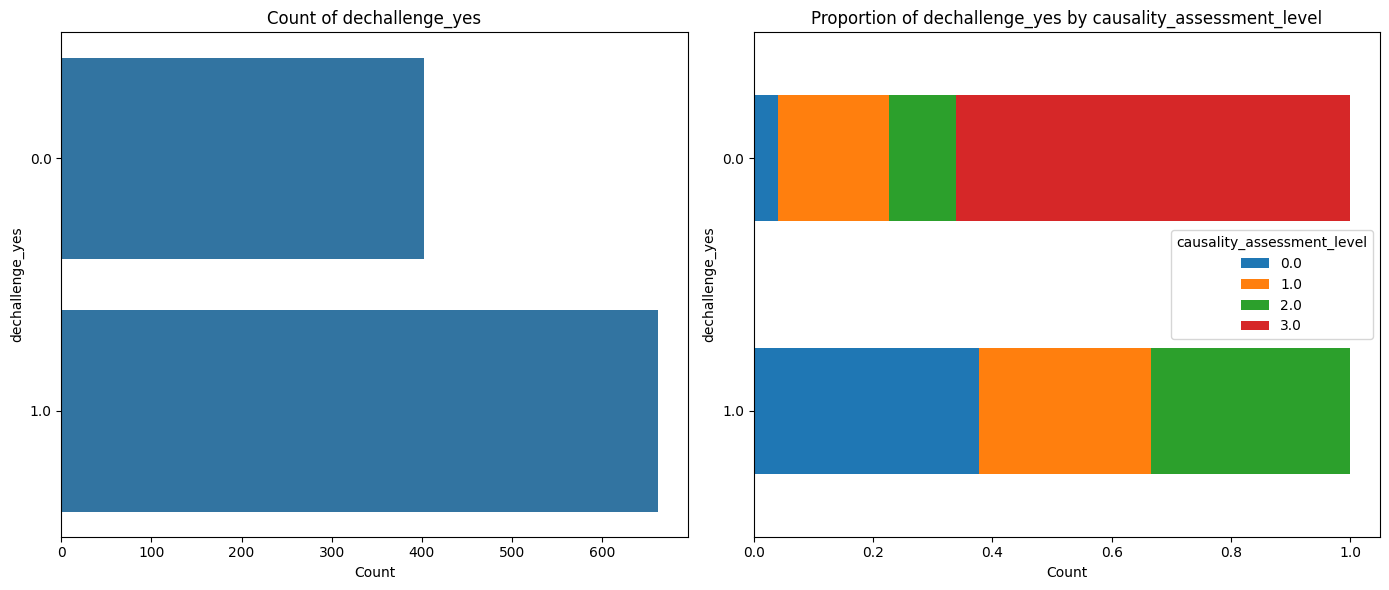

causality_assessment_level,0.0,1.0,2.0,3.0
rechallenge_yes,,,,
0.0,0.006547,0.122750,0.435352,0.435352
1.0,0.578366,0.421634,0.000000,0.000000


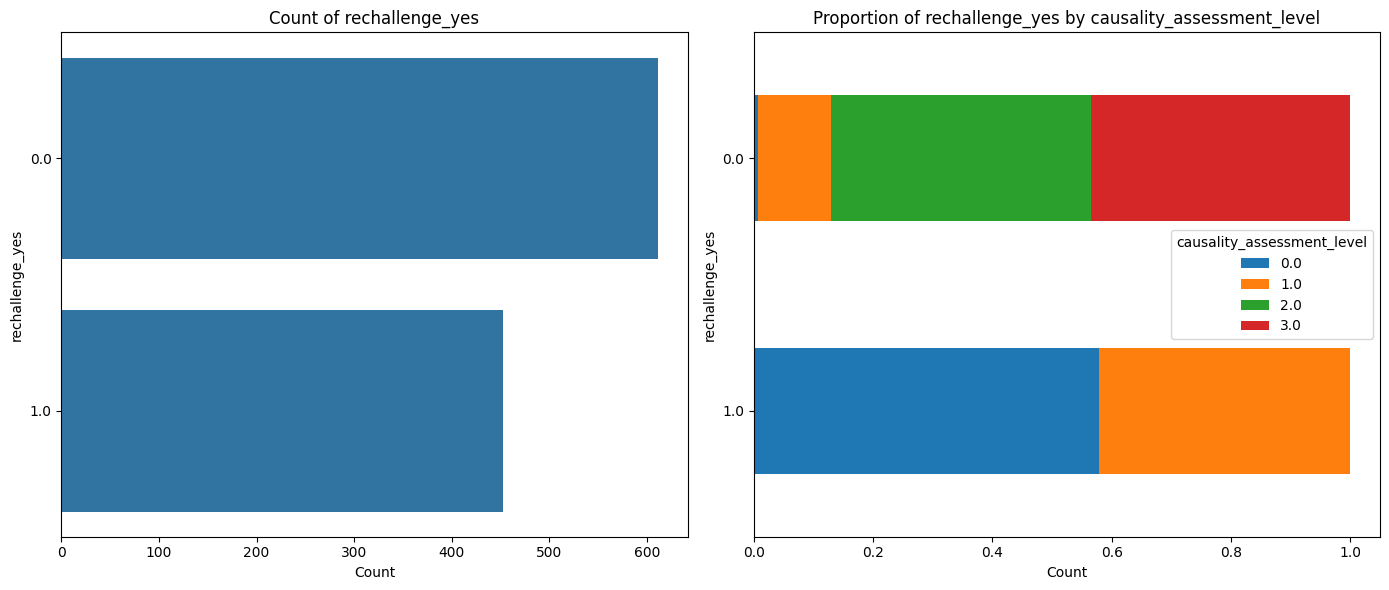

causality_assessment_level,0.0,1.0,2.0,3.0
severity_fatal,,,,
0.0,0.036939,0.344327,0.341689,0.277045
1.0,0.777778,0.016340,0.022876,0.183007


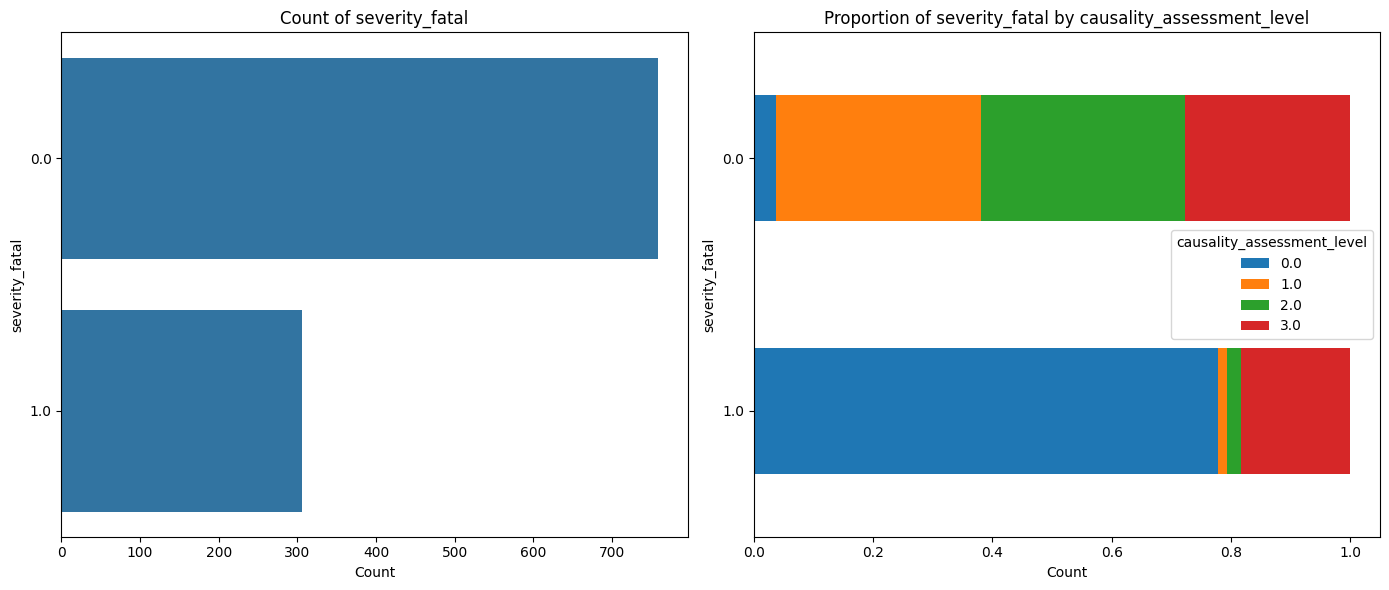

causality_assessment_level,0.0,1.0,2.0,3.0
num_suspected_drugs_1,,,,
0.0,0.005650,0.228814,0.500000,0.265537
1.0,0.371831,0.260563,0.125352,0.242254


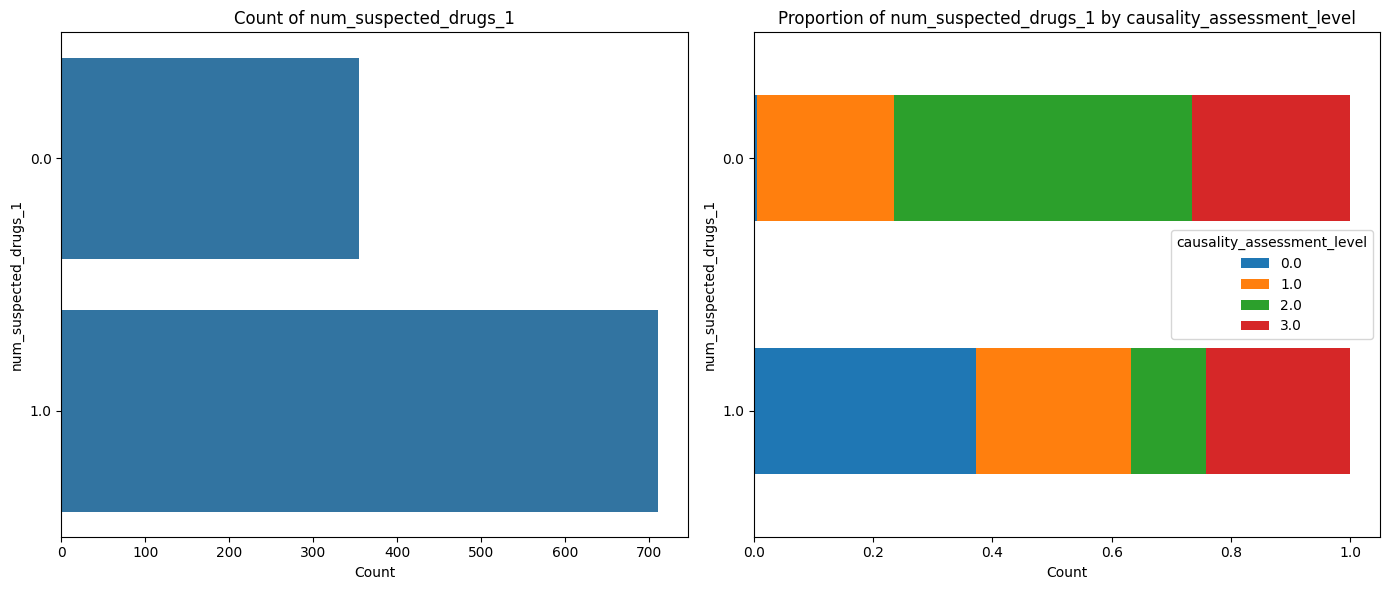

In [24]:
categorical_eda(
    df=df_for_final_eda,
    columns=optimal_categorical_and_boolean,
    target_column=target_column,
)

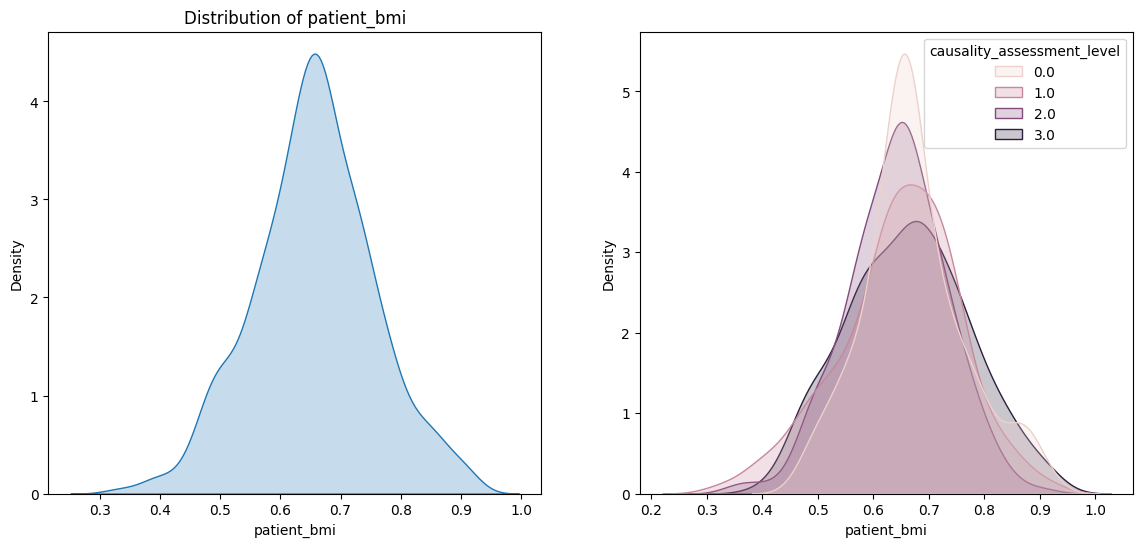

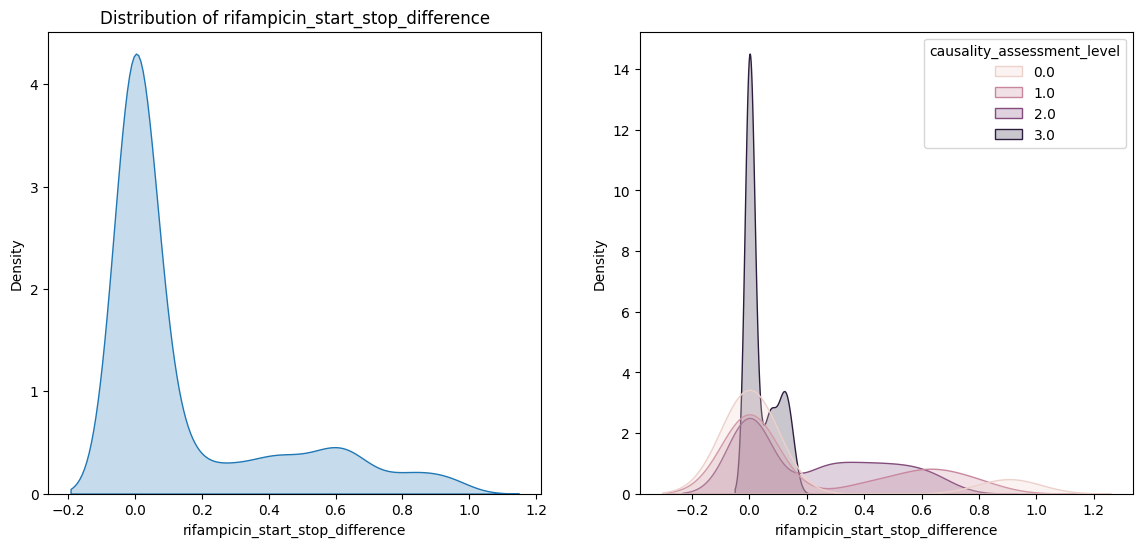

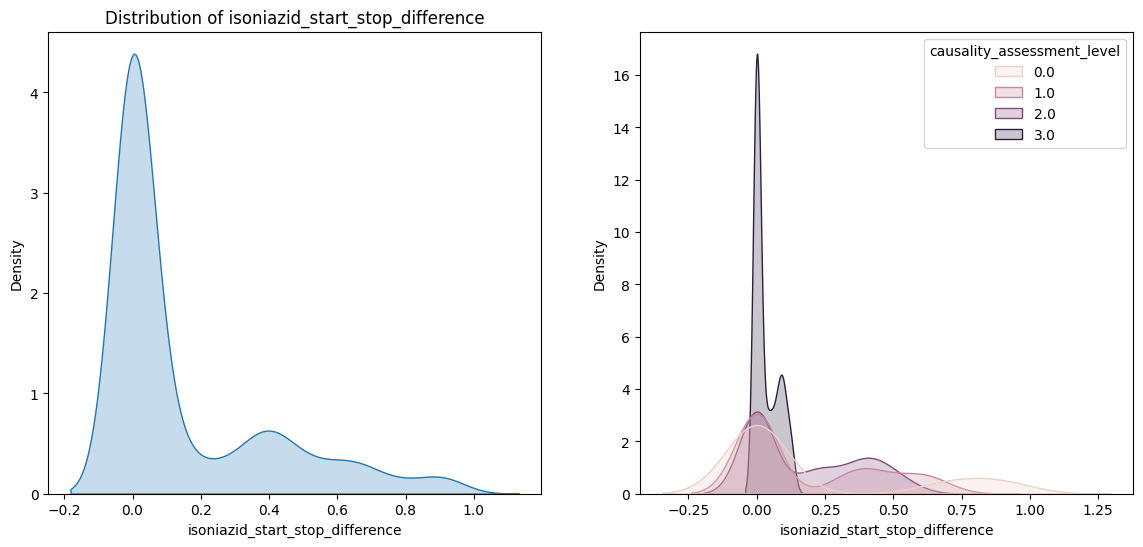

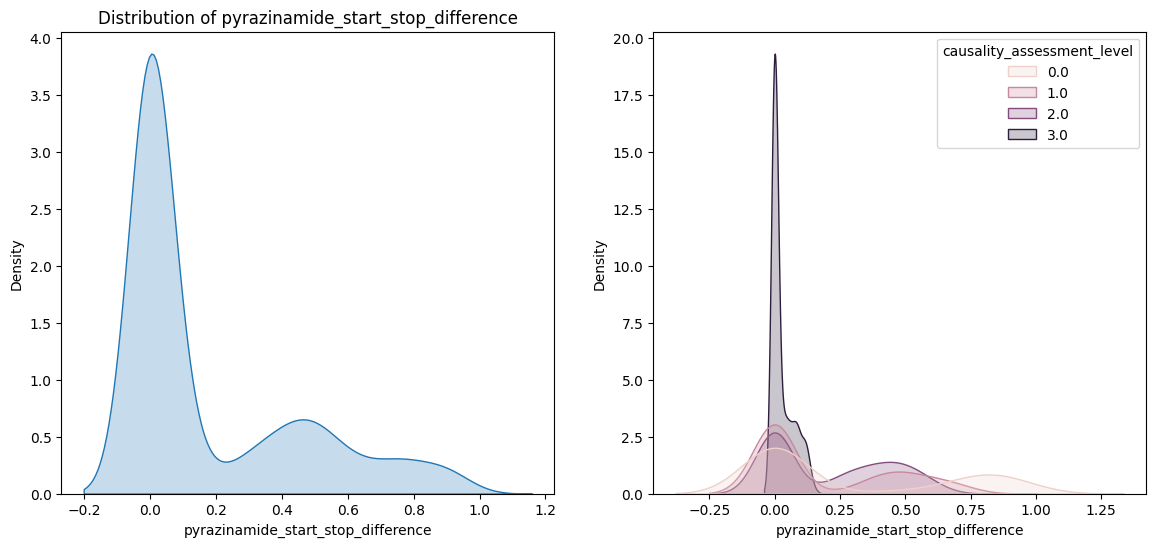

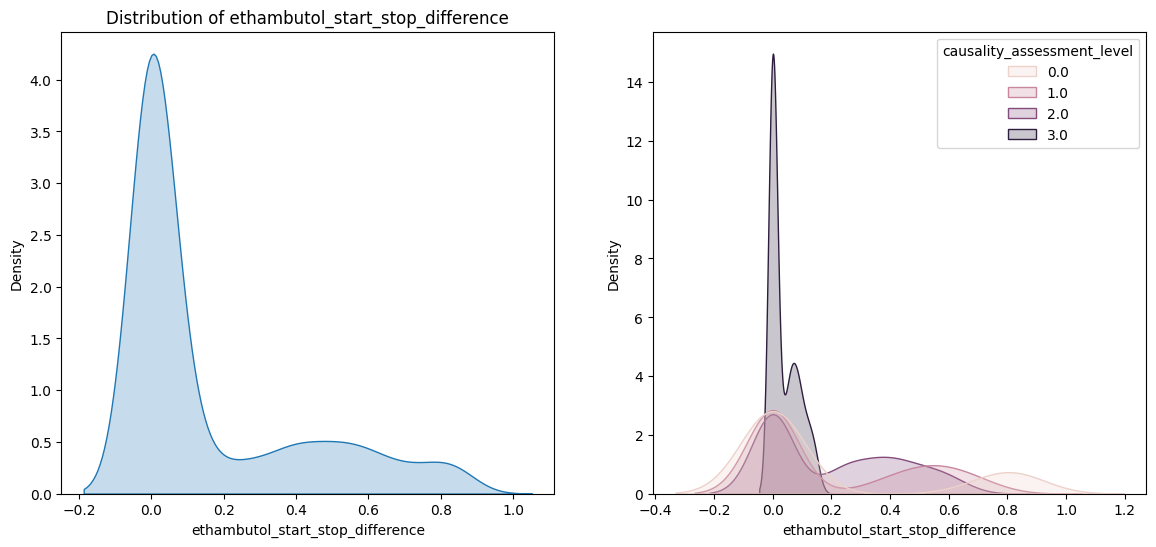

In [25]:
numerical_eda(
    df=df_for_final_eda, columns=optimal_numerical, target_column=target_column
)

# Model Training

In [26]:
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

estimators_and_param_grids = {
    "decision_tree": (
        DecisionTreeClassifier(random_state=42),
        {"max_depth": [25, 50, 100]},
    ),
    "ada_boost": (
        AdaBoostClassifier(algorithm="SAMME", random_state=42),
        {
            "n_estimators": [10, 50],
            "learning_rate": [0.1, 1.0],
        },
    ),
    "logistic_regression": (
        LogisticRegression(
            random_state=42, max_iter=1000, solver="lbfgs"
        ),
        {
            "C": [0.01, 0.1, 1, 10],
            "penalty": ["l2"],
        },
    ),
    "random_forest": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 30, 50],
            "max_features": ["auto", "sqrt", "log2"],
        },
    ),
    "gradient_boosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.8, 1.0],
        },
    ),
    "svm": (
        SVC(probability=True, random_state=42),
        {
            "kernel": ["linear", "rbf"],
            "C": [0.1, 1, 10],
            "gamma": ["scale", "auto"],
        },
    ),
    "knn": (
        KNeighborsClassifier(),
        {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            "p": [1, 2],  # 1 for Manhattan, 2 for Euclidean
        },
    ),
    "naive_bayes": (
        GaussianNB(),
        {},  # GaussianNB has no major hyperparameters for tuning
    ),
    # "xgb": (
    #     xgb.XGBClassifier(scale_pos_weight=1),
    #     {
    #         "n_estimators": [10, 50],
    #         "learning_rate": [0.1, 1.0],
    #         "min_child_weight": [1, 5],
    #         "gamma": [0.5, 1, 1.5],
    #         "subsample": [0.6, 0.8, 1.0],
    #         "colsample_bytree": [0.6, 0.8, 1.0],
    #         "max_depth": [3, 4, 5],
    #     },
    # ),
}


best_estimators = dict()
best_estimators_and_best_param_grids = dict()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

for estimator_name, estimator_and_param_grid in estimators_and_param_grids.items():
    (estimator, param_grid) = estimator_and_param_grid

    # search = GridSearchCV(
    #     estimator=estimator, param_grid=param_grid, scoring="f1", cv=cv, verbose=2
    # )
    print(estimator_name)
    print("---" * 50)

    search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_grid,
        cv=cv,
        n_iter=100,
        scoring="f1_weighted",
        verbose=2,
        n_jobs=-1,
    )

    search.fit(X_train_final[prediction_columns], y_train_encoded)

    best_estimator = search.best_estimator_
    # best_estimators[estimator_name] = best_estimator
    best_param_grid = search.best_params_

    best_estimators_and_best_param_grids[estimator_name] = (
        best_estimator,
        best_param_grid,
    )

    best_estimators[estimator_name] = best_estimator

    # print(estimator_name)
    # pprint(search.best_params_)

    # # Evaluate the model on the test data
    # accuracy = best_estimator.score(X_val, y_val)

    # y_pred = best_estimator.predict(X_val)

    # print("Accuracy:", accuracy)

    # classification_report = classification_report(y_val, y_pred)
    # report_dict = classification_report(y_val, y_pred, output_dict=True)

    # print(classification_report)

    print("-----" * 50)


decision_tree
------------------------------------------------------------------------------------------------------------------------------------------------------
Fitting 15 folds for each of 3 candidates, totalling 45 fits
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.1s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END .......................................max_depth=25; total time=   0.0s
[CV] END ....................................

Classification Report for decision_tree
              precision    recall  f1-score   support

     certain       0.64      0.54      0.58        13
      likely       0.85      0.81      0.83       111
    possible       0.78      0.85      0.82        73
    unlikely       0.98      1.00      0.99        53

    accuracy                           0.85       250
   macro avg       0.81      0.80      0.80       250
weighted avg       0.85      0.85      0.85       250




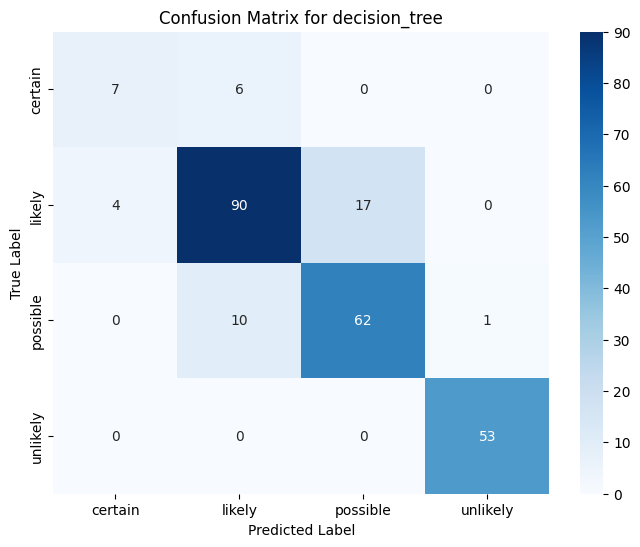

Classification Report for ada_boost
              precision    recall  f1-score   support

     certain       0.50      0.31      0.38        13
      likely       0.92      0.65      0.76       111
    possible       0.62      0.73      0.67        73
    unlikely       0.67      1.00      0.80        53

    accuracy                           0.73       250
   macro avg       0.68      0.67      0.65       250
weighted avg       0.76      0.73      0.72       250




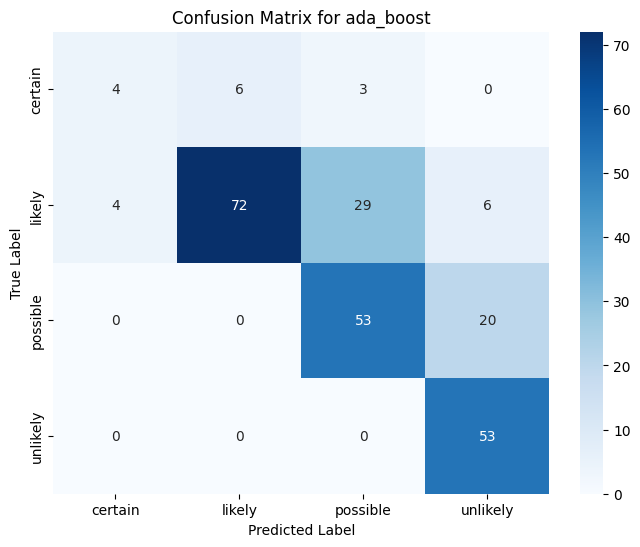

Classification Report for logistic_regression
              precision    recall  f1-score   support

     certain       0.67      0.62      0.64        13
      likely       0.91      0.74      0.82       111
    possible       0.73      0.89      0.80        73
    unlikely       0.90      1.00      0.95        53

    accuracy                           0.83       250
   macro avg       0.80      0.81      0.80       250
weighted avg       0.84      0.83      0.83       250




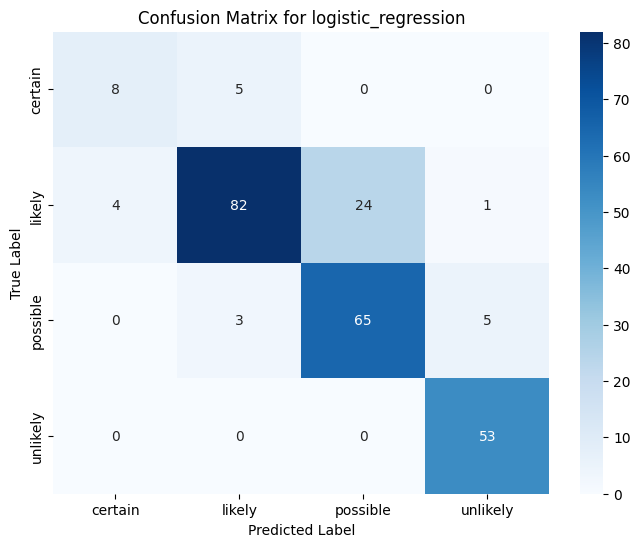

Classification Report for random_forest
              precision    recall  f1-score   support

     certain       0.75      0.69      0.72        13
      likely       0.89      0.84      0.87       111
    possible       0.80      0.88      0.84        73
    unlikely       0.98      1.00      0.99        53

    accuracy                           0.88       250
   macro avg       0.86      0.85      0.85       250
weighted avg       0.88      0.88      0.88       250




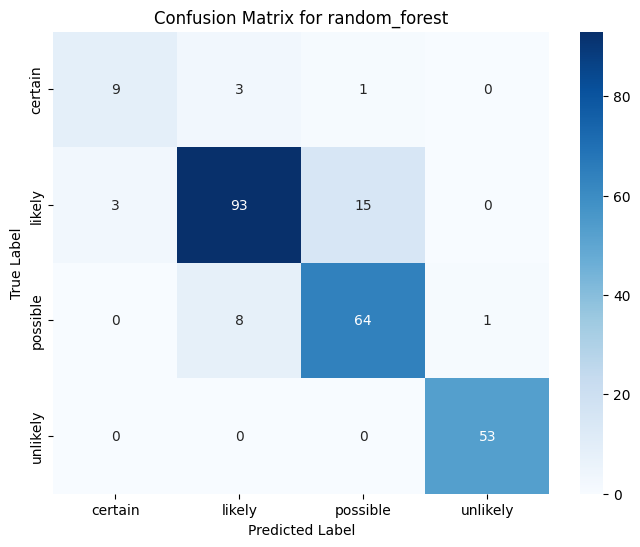

Classification Report for gradient_boosting
              precision    recall  f1-score   support

     certain       0.77      0.77      0.77        13
      likely       0.88      0.82      0.85       111
    possible       0.77      0.84      0.80        73
    unlikely       0.98      1.00      0.99        53

    accuracy                           0.86       250
   macro avg       0.85      0.86      0.85       250
weighted avg       0.86      0.86      0.86       250




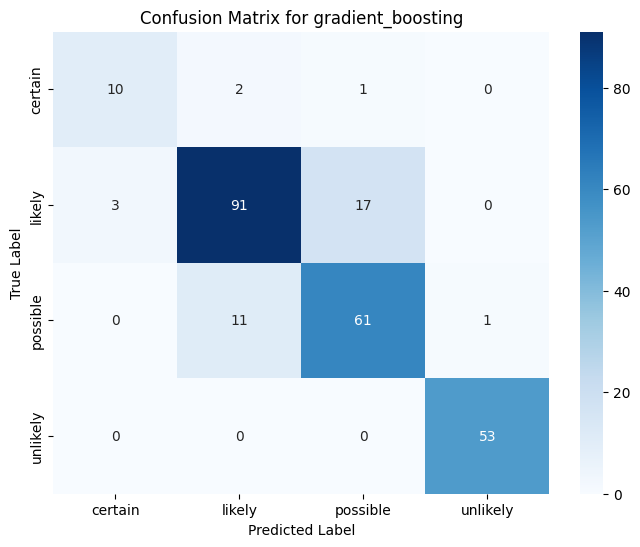

Classification Report for svm
              precision    recall  f1-score   support

     certain       0.77      0.77      0.77        13
      likely       0.89      0.77      0.83       111
    possible       0.74      0.86      0.80        73
    unlikely       0.93      1.00      0.96        53

    accuracy                           0.84       250
   macro avg       0.83      0.85      0.84       250
weighted avg       0.85      0.84      0.84       250




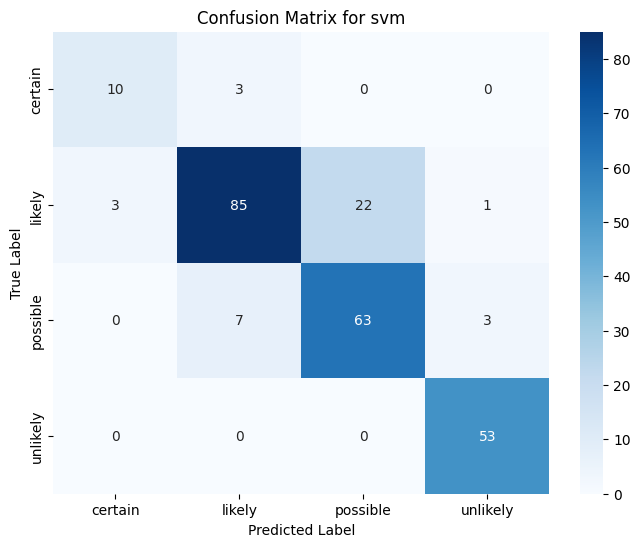

Classification Report for knn
              precision    recall  f1-score   support

     certain       0.64      0.54      0.58        13
      likely       0.87      0.79      0.83       111
    possible       0.76      0.85      0.80        73
    unlikely       0.95      1.00      0.97        53

    accuracy                           0.84       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.84      0.84      0.84       250




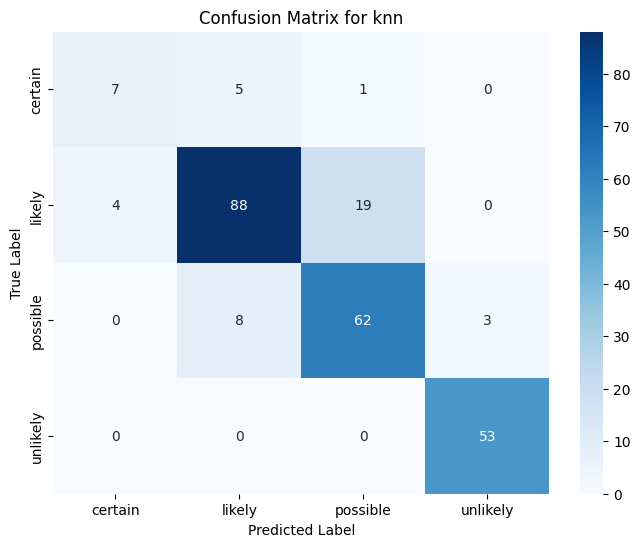

Classification Report for naive_bayes
              precision    recall  f1-score   support

     certain       0.67      0.31      0.42        13
      likely       0.93      0.67      0.77       111
    possible       0.65      0.96      0.77        73
    unlikely       0.95      1.00      0.97        53

    accuracy                           0.80       250
   macro avg       0.80      0.73      0.74       250
weighted avg       0.84      0.80      0.80       250




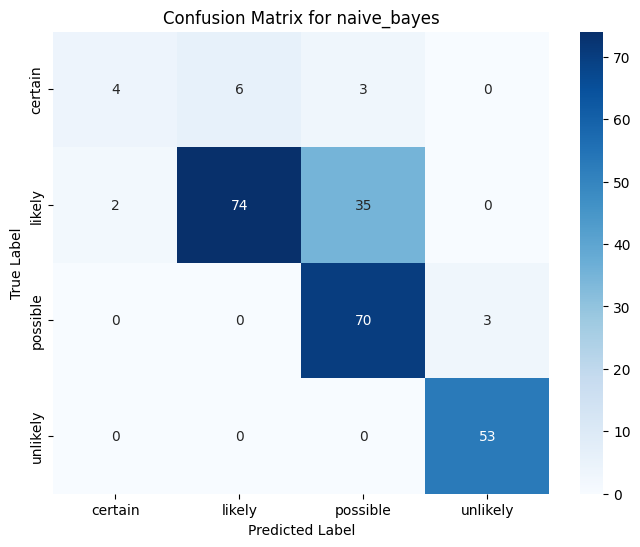

In [ ]:
from sklearn.metrics import confusion_matrix

for estimator_name, estimator in best_estimators.items():
    print("=" * 80)
    print(f"Classification Report for {estimator_name}")
    print("-" * 80)

    # Make predictions on the test set
    y_pred = estimator.predict(X_test_final[prediction_columns])

    # print(f"{y_test_encoded=}")
    # print(f"{y_pred=}")
    # Print classification report
    label_classes = ordinal_encoder.categories_[0]
    report = classification_report(
        y_test_encoded, y_pred, target_names = label_classes
    )
    print(report)


    cm = confusion_matrix(y_test_encoded, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_classes,
        yticklabels=label_classes,
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {estimator_name}")
    plt.show()

    print("=" * 80, "\n")

In [28]:
# (best_estimator, _) = best_estimators_and_best_param_grids["decision_tree"]

# accuracy = best_estimator.score(X_val_final[prediction_columns], y_val_encoded)

# y_pred = best_estimator.predict(X_val_final[prediction_columns])

# pprint(classification_report(y_val_encoded, y_pred, output_dict=True))


In [29]:
from mlflow.models import infer_signature
import mlflow
import json

for (
    estimator_name,
    best_estimator_and_best_param_grid,
) in best_estimators_and_best_param_grids.items():
    (best_estimator, best_param_grid) = best_estimator_and_best_param_grid
    # Evaluate the model on the test data
    accuracy = best_estimator.score(X_val_final[prediction_columns], y_val_encoded)

    y_pred = best_estimator.predict(X_val_final[prediction_columns])
    label_classes = ordinal_encoder.categories_[0]

    report = classification_report(y_val_encoded, y_pred, target_names=label_classes)
    report_dict = classification_report(y_val_encoded, y_pred, output_dict=True)
    class_report_dict = dict()

    report_renaming_map = {
        "0.0": "certain",
        "1.0": "likely",
        "2.0": "possible",
        "3.0": "unlikely",
    }

    for key in report_dict.keys():
        if key in report_renaming_map.keys():
            class_report_dict[report_renaming_map[key]] = report_dict[key]

    with mlflow.start_run(run_name=estimator_name):
        # Parameters
        mlflow.log_param("estimator_name", estimator_name)
        mlflow.log_params(param_grid)

        # # Convert params to JSON and save as an artifact
        # params_file_path = f"{temp_artifacts_path}/params.json"
        # with open(params_file_path, "w") as f:
        #     json.dump(param_grid, f, indent=4)

        # Metrics
        metrics_dict = {
            "accuracy": report_dict["accuracy"],
            "macro_avg_f1-score": report_dict["macro avg"]["f1-score"],
            "recall_class_certain": class_report_dict["certain"]["recall"],
            "recall_class_likely": class_report_dict["likely"]["recall"],
            "recall_class_possible": class_report_dict["possible"]["recall"],
            "recall_class_unlikely": class_report_dict["unlikely"]["recall"],
        }
        mlflow.log_metrics(metrics_dict)

        # # Convert metrics to JSON and save as an artifact
        # metrics_file_path = f"{temp_artifacts_path}/metrics.json"
        # with open(metrics_file_path, "w") as f:
        #     json.dump(metrics_dict, f, indent=4)

        # Artifacts
        ## Encoders
        temp_artifacts_path = "temp_artifacts"

        one_hot_encoder_path = f"{temp_artifacts_path}/one_hot_encoder.pkl"
        ordinal_encoder_path = f"{temp_artifacts_path}/ordinal_encoder.pkl"
        joblib.dump(one_hot_encoder, one_hot_encoder_path)
        joblib.dump(ordinal_encoder, ordinal_encoder_path)

        mlflow.log_artifact(one_hot_encoder_path, artifact_path="encoders")
        mlflow.log_artifact(ordinal_encoder_path, artifact_path="encoders")

        model_columns = {
            "categorical_columns": categorical_columns,
            "numerical_columns": numerical_columns,
            "date_columns": date_columns,
            "boolean_columns": boolean_columns,
            "prediction_columns": prediction_columns,
            "columns_to_drop": columns_to_drop,
        }

        with open(f"{temp_artifacts_path}/model_columns.json", "w") as f:
            json.dump(model_columns, f, indent=4)

        ## Scalers
        scaler_path = f"{temp_artifacts_path}/minmax_scaler.pkl"
        joblib.dump(scaler, scaler_path)
        mlflow.log_artifact(scaler_path, artifact_path="scalers")

        ## Column Metadata
        mlflow.log_artifact(
            f"{temp_artifacts_path}/model_columns.json", artifact_path="metadata"
        )

        # Model
        signature = infer_signature(
            X_train_final[prediction_columns],
            best_estimator.predict(X_train_final[prediction_columns]),
        )
        # mlflow.sklearn.log_model(best_estimator, estimator_name, signature=signature)
        # Log and register the model
        model_info = mlflow.sklearn.log_model(
            sk_model=best_estimator,
            artifact_path="model",
            signature=signature,
            registered_model_name=MLFLOW_MODEL_NAME,  # Register the model with a fixed name
        )

        # Set alias 'champion' to this model version
        client = mlflow.MlflowClient()
        latest_version = client.get_latest_versions(MLFLOW_MODEL_NAME, stages=["None"])[
            0
        ].version  # Get the latest version
        client.set_registered_model_alias(
            MLFLOW_MODEL_NAME, MLFLOW_MODEL_ALIAS, latest_version
        )  # Assign alias

Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 31
Created version '31' of model 'final_ml_model'.


🏃 View run decision_tree at: http://127.0.0.1:5001/#/experiments/1/runs/37053ef4dcc3486d9b95cbbe9dabf1ce
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 32
Created version '32' of model 'final_ml_model'.


🏃 View run ada_boost at: http://127.0.0.1:5001/#/experiments/1/runs/b287fca3ebd54a8f8773bd51fbe0e34d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 33
Created version '33' of model 'final_ml_model'.


🏃 View run logistic_regression at: http://127.0.0.1:5001/#/experiments/1/runs/fe448d402e0d43c2be50c6dd3129825d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 34
Created version '34' of model 'final_ml_model'.


🏃 View run random_forest at: http://127.0.0.1:5001/#/experiments/1/runs/0e3dc93618a840298ebda9d43c756f82
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:22 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 35
Created version '35' of model 'final_ml_model'.


🏃 View run gradient_boosting at: http://127.0.0.1:5001/#/experiments/1/runs/fd295fee7e5c456c80073b9b28bb8eca
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:26 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 36
Created version '36' of model 'final_ml_model'.


🏃 View run svm at: http://127.0.0.1:5001/#/experiments/1/runs/7fa5ee89218943f79638c78c56a8a7b5
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 37
Created version '37' of model 'final_ml_model'.


🏃 View run knn at: http://127.0.0.1:5001/#/experiments/1/runs/9ecff62136c7413b85d7ff935040d717
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Registered model 'final_ml_model' already exists. Creating a new version of this model...
2025/05/30 02:11:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: final_ml_model, version 38


🏃 View run naive_bayes at: http://127.0.0.1:5001/#/experiments/1/runs/b73cdf12cbca429f9c62c5b90f17ec17
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/1


Created version '38' of model 'final_ml_model'.


In [30]:
# import os

# import joblib
# from dotenv import load_dotenv

# load_dotenv()

# ML_MODEL_PATH = os.getenv("ML_MODEL_PATH")
# joblib.dump(best_estimators_and_best_param_grids["decision_tree"][0], ML_MODEL_PATH)

In [31]:
# run_id = input("Run ID: ").strip()
# model_name = input("Model Name: ").strip()
# model_uri = f"runs:/{run_id}/{model_name}"

# result = mlflow.register_model(model_uri, model_name)